# Wrangle

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from fitter import Fitter
import numpy as np


def read_data(file):
    """Reads the first 4 columns from the given file and drops empty rows."""
    data = pd.read_csv(file, delimiter=',', usecols=[0, 1, 2, 3],
                       parse_dates=[[0, 1]])
    data.columns = ['date', 'm', 'v']
    data = data[data['date'] != 'nan nan']
    data = data.dropna(how='all')
    data['date'] = pd.to_datetime(data['date'])
    return data


data_1 = read_data('data/out_1.csv')
data_1['zone'] = 1
data_2 = read_data('data/out_2.csv')
data_2['zone'] = 2
df = pd.concat([data_1, data_2])

## Time Differences and Energy

In [2]:
def get_time_differences(df):
    """Returns the time differences between rocks in hours."""
    return df['date'].diff().dt.total_seconds() / 3600


def add_time_differences(df):
    """Adds the time differences to the dataframe."""
    df['time_differences'] = get_time_differences(df)
    return df


def add_energy(df):
    """Adds the energy to the dataframe."""
    df['e'] = 0.5 * df['m'] * df['v'] ** 2
    return df


def reorder_columns(df):
    """Reorders the columns of the dataframe."""
    return df[['zone', 'date', 'time_differences', 'm', 'v', 'e']]


data_1 = reorder_columns(add_energy(add_time_differences(data_1)))
data_2 = reorder_columns(add_energy(add_time_differences(data_2)))
df = reorder_columns(add_energy(add_time_differences(df)))
df['zone'] = df['zone'].astype('category')


## Write data to disk

In [3]:
data_1.to_csv('data/data_1.csv', index=False)
data_2.to_csv('data/data_1.csv', index=False)
df.to_csv('data/data.csv', index=False)

# Visualization
## Scatter

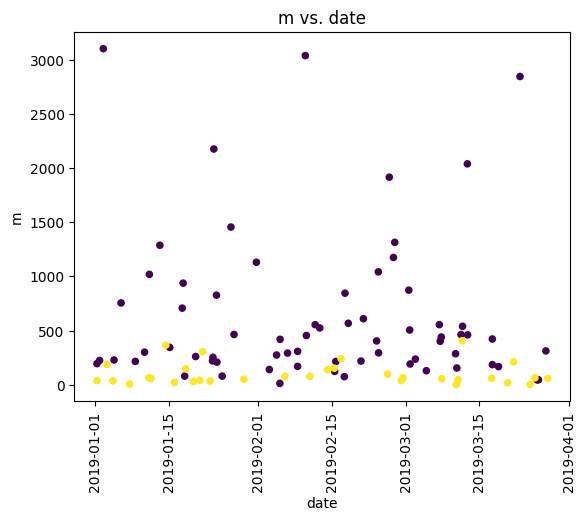

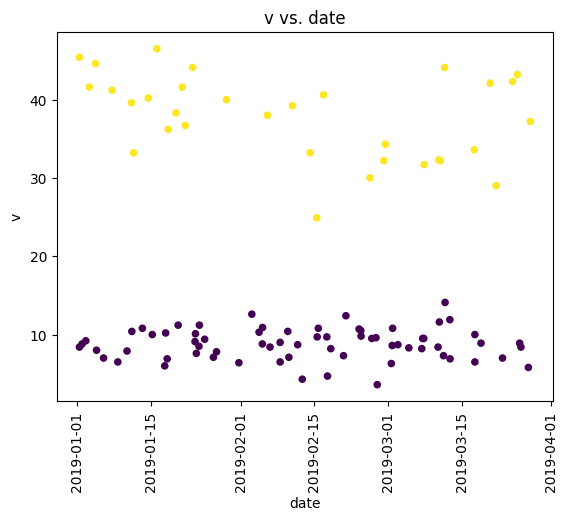

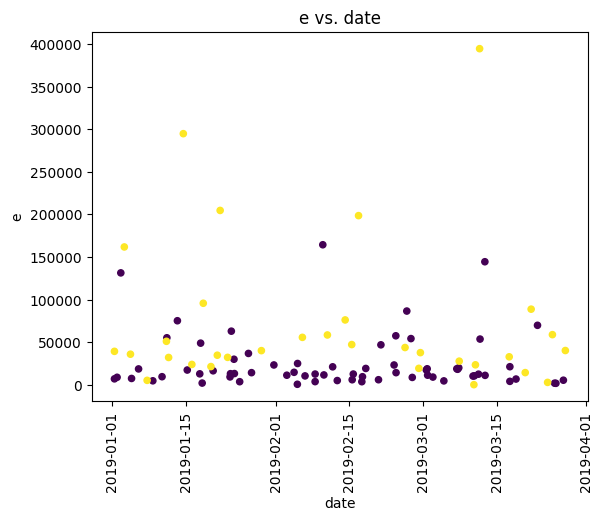

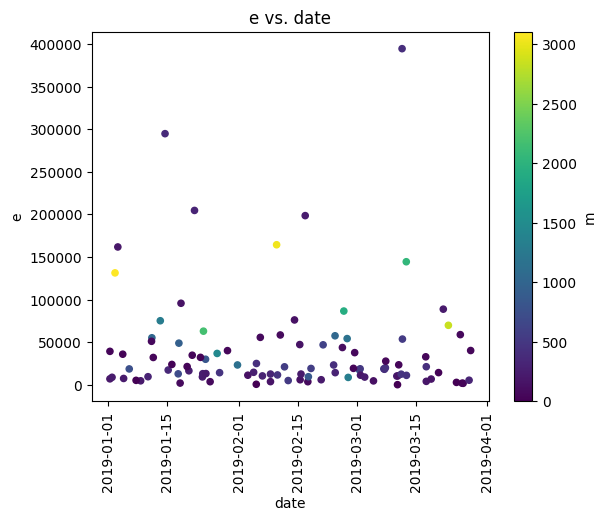

In [4]:
def scatter_plot(df: pd.DataFrame, col: str, c='zone', colorbar=False,
                 colormap='viridis'):
    """Plots the given column of the given dataframe as a scatter plot."""
    df['date'] = pd.to_datetime(df['date'])
    ax = df.plot.scatter(x='date', y=col, c=c, colorbar=colorbar,
                         colormap=colormap, title=f'{col} vs. date')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=90)


for col in ['m', 'v', 'e']:
    scatter_plot(df, col)
scatter_plot(df, 'e', c='m', colorbar=True)
plt.show()

## Histogram

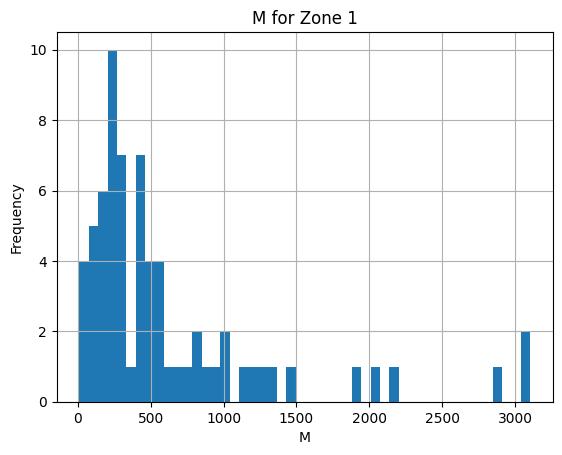

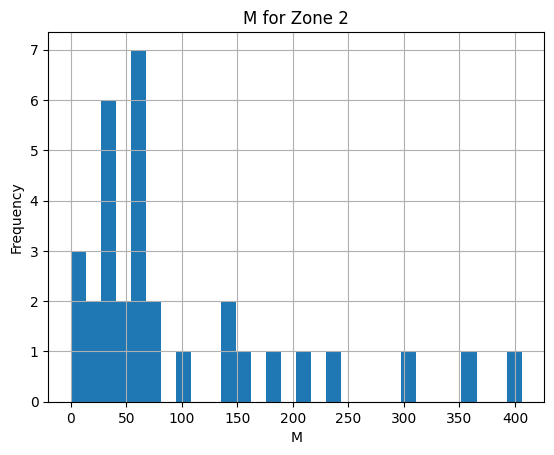

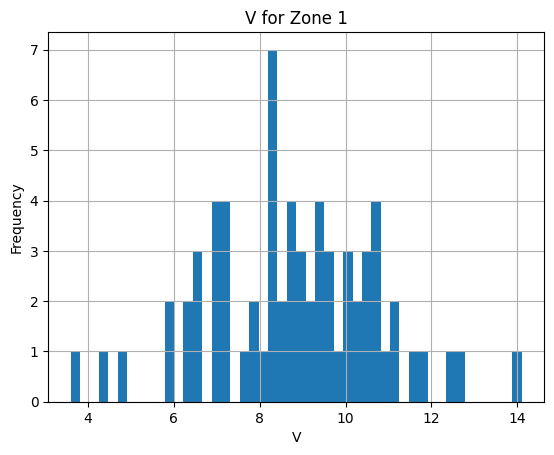

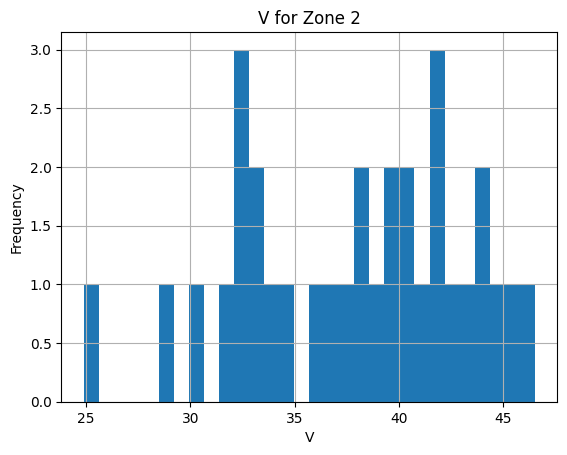

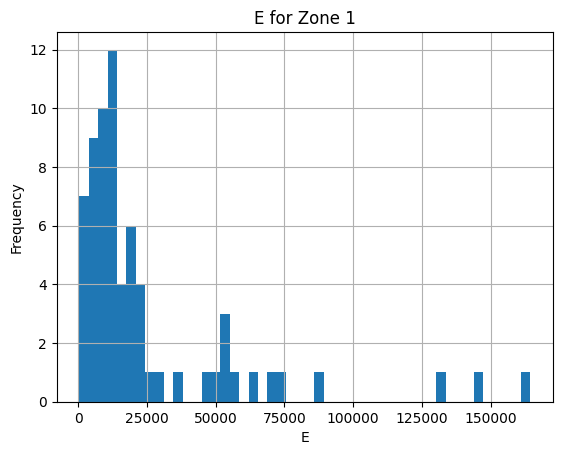

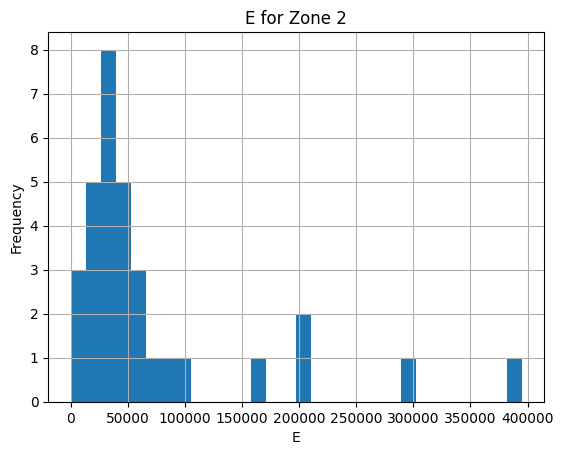

In [5]:
def plot_histogram(df: pd.DataFrame, col: str, zone: int):
    """Plots the given column of the given dataframe as a histogram."""
    df[col].hist(bins=np.sqrt(len(df[col])).astype(int) * 6)
    plt.title(f'{col.upper()} for Zone {zone}')
    plt.xlabel(col.upper())
    plt.ylabel('Frequency')
    plt.show()


for col in ['m', 'v', 'e']:
    for zone in [1, 2]:
        plot_histogram(df[df['zone'] == zone], col, zone)


# Fit Distributions

In [5]:
def fit_common_distributions(data):
    """Fits the given data to the most common distributions and returns the fitted object."""
    f = Fitter(data, distributions=['norm', 'expon', 'gamma', 'lognorm', 'poison', 'beta',
                         'standard_normal', 'binomial', 'chauchy', 'pareto',
                         'weibull_min', 'weibull_max'])
    f.fit()
    return f


def show_best_distribution(data):
    """Fits the given data to the most common distributions, prints the best distribution and shows a plot of the best distributions."""
    f = fit_common_distributions(data)
    print(f.get_best())
    f.summary()

Fitting 12 distributions:   0%|          | 0/12 [00:00<?, ?it/s]SKIPPED poison distribution (taking more than 30 seconds)
SKIPPED standard_normal distribution (taking more than 30 seconds)
SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 23.90it/s]


{'beta': {'a': 0.6997644509440446, 'b': 3.4948819059403973, 'loc': -1.5731268279153073e-29, 'scale': 176.9027805107536}}


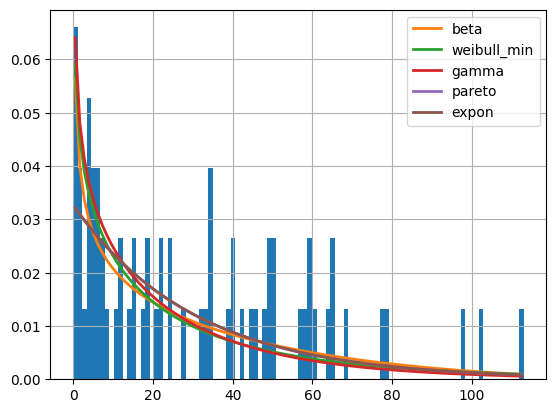

In [6]:
show_best_distribution(df[df['zone'] == 1]['time_differences'].dropna().values)

Fitting 12 distributions:   0%|          | 0/12 [00:00<?, ?it/s]SKIPPED poison distribution (taking more than 30 seconds)
SKIPPED standard_normal distribution (taking more than 30 seconds)
Fitting 12 distributions:  42%|████▏     | 5/12 [00:00<00:00, 47.99it/s]SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 28.69it/s]


{'beta': {'a': 169139115.46018183, 'b': 1.2012440293266566, 'loc': -29788388137.25114, 'scale': 29788388350.7942}}


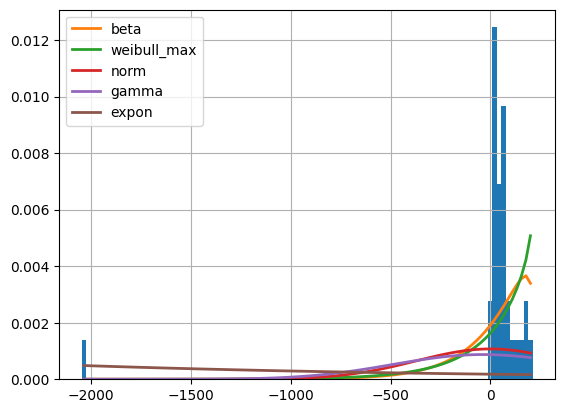

In [7]:
show_best_distribution(df[df['zone'] == 2]['time_differences'].dropna().values)

Fitting 12 distributions:   0%|          | 0/12 [00:00<?, ?it/s]SKIPPED poison distribution (taking more than 30 seconds)
SKIPPED standard_normal distribution (taking more than 30 seconds)
SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 29.44it/s]


{'expon': {'loc': 12.0, 'scale': 616.6323529411765}}


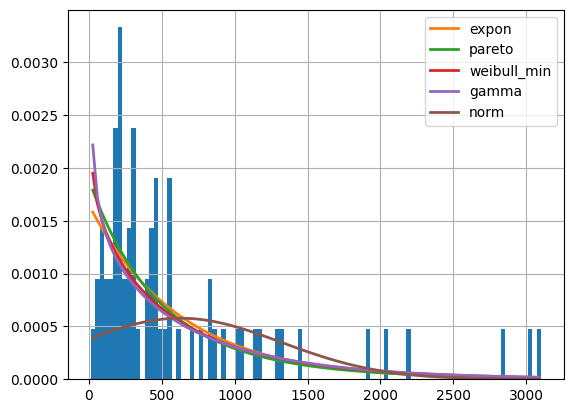

In [8]:
show_best_distribution(df[df['zone'] == 1]['m'].dropna().values)

Fitting 12 distributions:   8%|▊         | 1/12 [00:00<00:01,  8.16it/s]SKIPPED standard_normal distribution (taking more than 30 seconds)
SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 22.74it/s]


{'expon': {'loc': 0.0, 'scale': 99.25}}


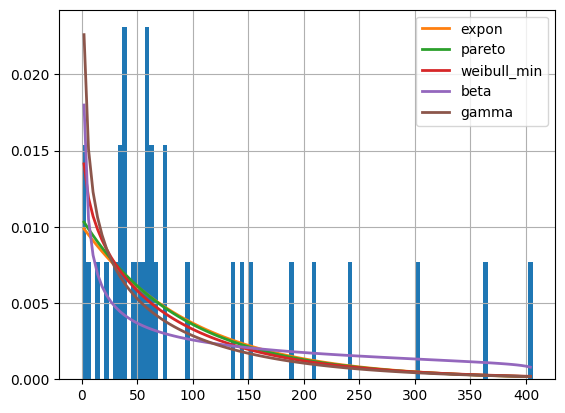

In [9]:
show_best_distribution(df[df['zone'] == 2]['m'].dropna().values)

Fitting 12 distributions:   0%|          | 0/12 [00:00<?, ?it/s]SKIPPED poison distribution (taking more than 30 seconds)
SKIPPED standard_normal distribution (taking more than 30 seconds)
SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 35.71it/s]


{'beta': {'a': 4529938.7775074905, 'b': 365.72349932754736, 'loc': -467477.1982099542, 'scale': 467523.7299867311}}


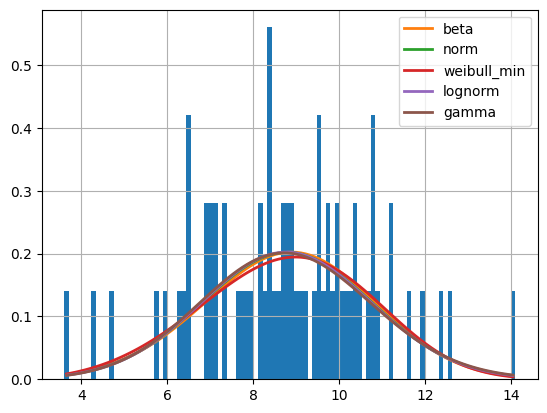

In [10]:
show_best_distribution(df[df['zone'] == 1]['v'].dropna().values)

Fitting 12 distributions:   0%|          | 0/12 [00:00<?, ?it/s]SKIPPED poison distribution (taking more than 30 seconds)
SKIPPED standard_normal distribution (taking more than 30 seconds)
SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 38.33it/s]


{'beta': {'a': 2.135456049863241, 'b': 1.2827668923945292, 'loc': 23.092130432299154, 'scale': 23.56888476645474}}


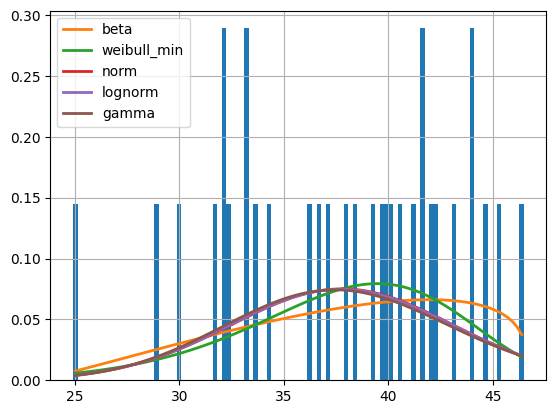

In [11]:
show_best_distribution(df[df['zone'] == 2]['v'].dropna().values)

Fitting 12 distributions:   0%|          | 0/12 [00:00<?, ?it/s]SKIPPED poison distribution (taking more than 30 seconds)
SKIPPED standard_normal distribution (taking more than 30 seconds)
SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 29.52it/s]


{'lognorm': {'s': 1.0474041303558448, 'loc': -380.63786381920573, 'scale': 14630.35739041989}}


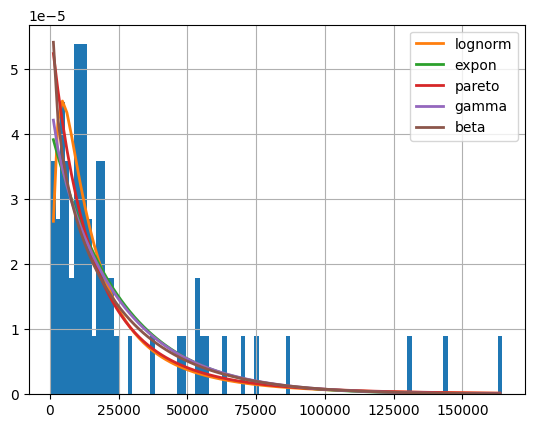

In [12]:
show_best_distribution(df[df['zone'] == 1]['e'].dropna().values)

Fitting 12 distributions:   0%|          | 0/12 [00:00<?, ?it/s]SKIPPED poison distribution (taking more than 30 seconds)
SKIPPED standard_normal distribution (taking more than 30 seconds)
SKIPPED binomial distribution (taking more than 30 seconds)
SKIPPED chauchy distribution (taking more than 30 seconds)
Fitting 12 distributions: 100%|██████████| 12/12 [00:00<00:00, 22.56it/s]


{'expon': {'loc': 0.0, 'scale': 71598.225}}


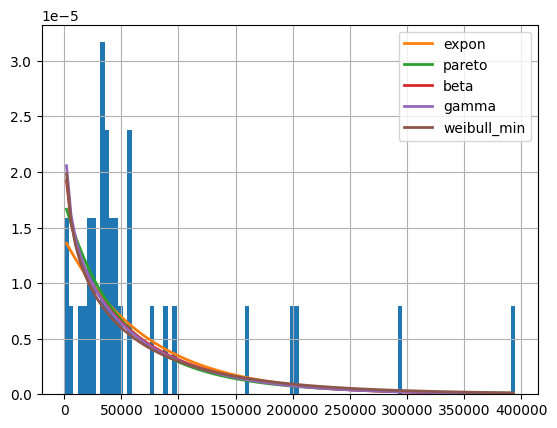

In [13]:
show_best_distribution(df[df['zone'] == 2]['e'].dropna().values)